# Preparing the environment

### Connecting to Kaggle via Colab

In [1]:
#install Kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"houssemmedinedrissi","key":"fd6b969da4404c9f519cc5aaa7c8a980"}'}

In [3]:
#create a kaggle folder
!mkdir ~/.kaggle

In [4]:
#copy kaggle.json file into created folder
!cp kaggle.json ~/.kaggle/ 

In [5]:
#Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

### Importing dataset from Kaggle

In [6]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

 94% 140M/149M [00:00<00:00, 145MB/s]
100% 149M/149M [00:00<00:00, 177MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip

## Exploring dataset 

### Import Necessary Libraries

In [ ]:
pip install scikit-plot

In [49]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score
import scikitplot as skplt

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

### Reading the Dataset

In [9]:
train_dir = '/content/Training'
test_dir = '/content/Testing'

train_paths = []
train_labels = []

test_paths = []
test_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+"//" +label):
        test_paths.append(test_dir + '//'+label+ '//'+image)
        test_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
test_paths, test_labels = shuffle(test_paths, test_labels)

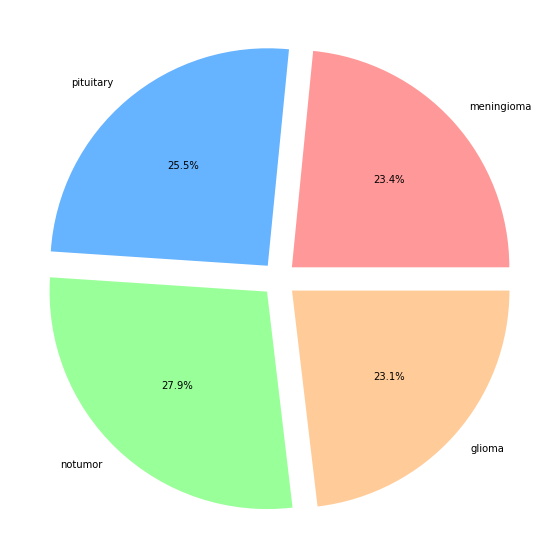

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


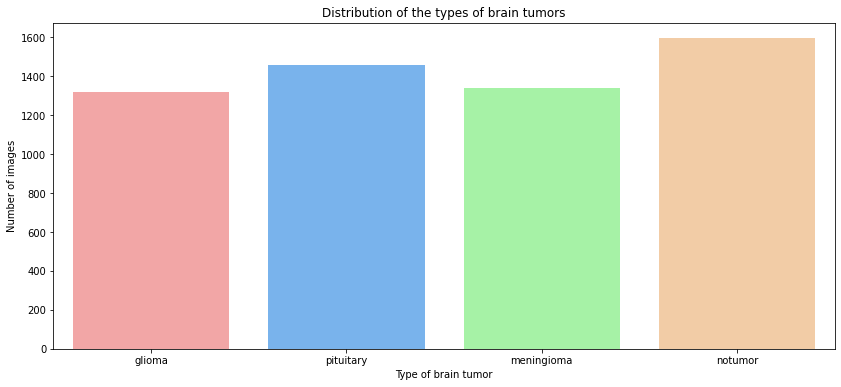

In [10]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie([len(os.listdir(train_dir+"//" +label)) 
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08) 
           ,autopct='%1.1f%%')
plt.show()




plt.figure(figsize=(14,6))
sns.countplot(train_labels, palette=colors)
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

### But what are those labels ?
- Not tumor: indicates that those images do not contain a tumor.
- meningioma: is a type of tumor that develops from the membranes that surround the brain and spinal cord.
- glioma: is a type of tumor that develops from glial cells, which are cells that support and protect neurons.
- pituitary tumor: is a type of tumor that develops from the pituitary gland, which is located at the base of the brain.

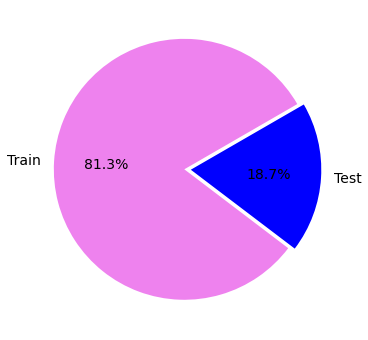

In [11]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

### Data augmentation 

In [13]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

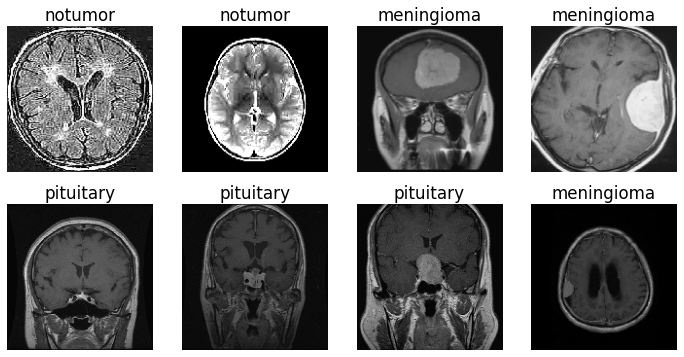

In [14]:
IMAGE_SIZE = 150


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [15]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=32, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

## Vgg16 Model

In [19]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 18,911,556
Trainable params: 11,276,292


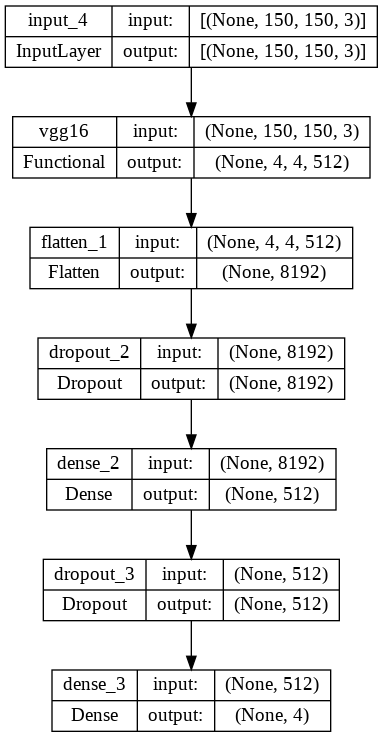

In [22]:
plot_model(model, show_shapes=True)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

### Training the model

In [24]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 6
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/6
178/178 [==============================] - 1066s 6s/step - loss: 0.4263 - sparse_categorical_accuracy: 0.8369
Epoch 2/6
178/178 [==============================] - 1060s 6s/step - loss: 0.2082 - sparse_categorical_accuracy: 0.9208
Epoch 3/6
178/178 [==============================] - 1061s 6s/step - loss: 0.1272 - sparse_categorical_accuracy: 0.9486
Epoch 4/6
178/178 [==============================] - 1060s 6s/step - loss: 0.1078 - sparse_categorical_accuracy: 0.9607
Epoch 5/6
178/178 [==============================] - 1062s 6s/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9715
Epoch 6/6
178/178 [==============================] - 1061s 6s/step - loss: 0.0640 - sparse_categorical_accuracy: 0.9752


### Accuracy and Loss Visualization

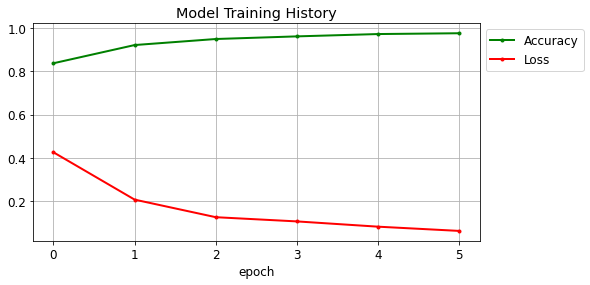

In [26]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Model Saving

In [27]:
model.save('Basic_Vgg16.h5')

### Getting model predictions : Classification Report

In [28]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  2%|▎         | 1/40 [00:06<03:56,  6.07s/it]

1/1 [==============================] - 5s 5s/step


  5%|▌         | 2/40 [00:11<03:27,  5.46s/it]

1/1 [==============================] - 5s 5s/step


  8%|▊         | 3/40 [00:16<03:16,  5.30s/it]

1/1 [==============================] - 5s 5s/step


 10%|█         | 4/40 [00:21<03:06,  5.19s/it]

1/1 [==============================] - 5s 5s/step


 12%|█▎        | 5/40 [00:26<02:59,  5.14s/it]

1/1 [==============================] - 5s 5s/step


 15%|█▌        | 6/40 [00:31<02:53,  5.10s/it]

1/1 [==============================] - 5s 5s/step


 18%|█▊        | 7/40 [00:36<02:47,  5.08s/it]

1/1 [==============================] - 5s 5s/step


 20%|██        | 8/40 [00:41<02:42,  5.07s/it]

1/1 [==============================] - 5s 5s/step


 22%|██▎       | 9/40 [00:46<02:36,  5.06s/it]

1/1 [==============================] - 5s 5s/step


 25%|██▌       | 10/40 [00:51<02:31,  5.05s/it]

1/1 [==============================] - 5s 5s/step


 28%|██▊       | 11/40 [00:56<02:26,  5.06s/it]

1/1 [==============================] - 5s 5s/step


 30%|███       | 12/40 [01:02<02:25,  5.19s/it]

1/1 [==============================] - 5s 5s/step


 32%|███▎      | 13/40 [01:07<02:18,  5.14s/it]

1/1 [==============================] - 6s 6s/step


 35%|███▌      | 14/40 [01:12<02:18,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 38%|███▊      | 15/40 [01:17<02:10,  5.23s/it]

1/1 [==============================] - 5s 5s/step


 40%|████      | 16/40 [01:22<02:04,  5.18s/it]

1/1 [==============================] - 5s 5s/step


 42%|████▎     | 17/40 [01:27<01:58,  5.14s/it]

1/1 [==============================] - 5s 5s/step


 45%|████▌     | 18/40 [01:32<01:52,  5.12s/it]

1/1 [==============================] - 6s 6s/step


 48%|████▊     | 19/40 [01:39<01:54,  5.46s/it]

1/1 [==============================] - 5s 5s/step


 50%|█████     | 20/40 [01:44<01:46,  5.34s/it]

1/1 [==============================] - 6s 6s/step


 52%|█████▎    | 21/40 [01:50<01:47,  5.68s/it]

1/1 [==============================] - 5s 5s/step


 55%|█████▌    | 22/40 [02:01<02:08,  7.11s/it]

1/1 [==============================] - 5s 5s/step


 57%|█████▊    | 23/40 [02:06<01:50,  6.50s/it]

1/1 [==============================] - 5s 5s/step


 60%|██████    | 24/40 [02:11<01:37,  6.07s/it]

1/1 [==============================] - 5s 5s/step


 62%|██████▎   | 25/40 [02:16<01:26,  5.77s/it]

1/1 [==============================] - 5s 5s/step


 65%|██████▌   | 26/40 [02:21<01:17,  5.55s/it]

1/1 [==============================] - 5s 5s/step


 68%|██████▊   | 27/40 [02:26<01:10,  5.39s/it]

1/1 [==============================] - 5s 5s/step


 70%|███████   | 28/40 [02:31<01:03,  5.27s/it]

1/1 [==============================] - 5s 5s/step


 72%|███████▎  | 29/40 [02:36<00:57,  5.19s/it]

1/1 [==============================] - 5s 5s/step


 75%|███████▌  | 30/40 [02:41<00:51,  5.13s/it]

1/1 [==============================] - 5s 5s/step


 78%|███████▊  | 31/40 [02:46<00:45,  5.10s/it]

1/1 [==============================] - 5s 5s/step


 80%|████████  | 32/40 [02:51<00:40,  5.08s/it]

1/1 [==============================] - 5s 5s/step


 82%|████████▎ | 33/40 [02:56<00:35,  5.07s/it]

1/1 [==============================] - 5s 5s/step


 85%|████████▌ | 34/40 [03:01<00:30,  5.06s/it]

1/1 [==============================] - 5s 5s/step


 88%|████████▊ | 35/40 [03:06<00:25,  5.05s/it]

1/1 [==============================] - 5s 5s/step


 90%|█████████ | 36/40 [03:11<00:20,  5.05s/it]

1/1 [==============================] - 5s 5s/step


 92%|█████████▎| 37/40 [03:16<00:15,  5.04s/it]

1/1 [==============================] - 5s 5s/step


 95%|█████████▌| 38/40 [03:21<00:10,  5.04s/it]

1/1 [==============================] - 5s 5s/step


 98%|█████████▊| 39/40 [03:26<00:05,  5.04s/it]

1/1 [==============================] - 7s 7s/step


100%|██████████| 40/40 [03:33<00:00,  5.65s/it]

1/1 [==============================] - 5s 5s/step


41it [03:39,  5.35s/it]


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.99      0.81      0.89       300
  meningioma       0.83      0.93      0.88       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.92      1.00      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



### Showing Confusion Matrix

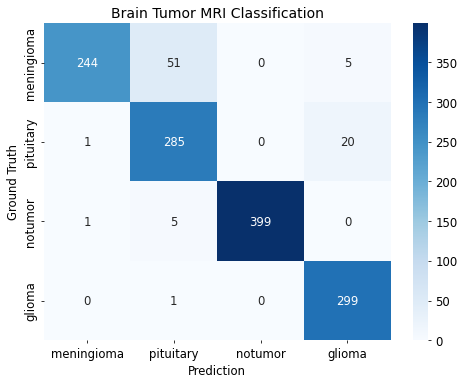

In [32]:
cnf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)